In [30]:
%reset
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import random
import treecorr
from astropy.io import fits
import pickle as pk
import os.path
from os import path
# import fitsio
# from fitsio import FITS,FITSHDR



Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [31]:
cat_old = fits.open('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/process_cats/matter_ra_dec_r_z_bin_jk_L3072N4096-LC129-1in700_njkradec_180_njkz_1.fits')

ra_o, dec_o, z_o = cat_old[1].data['RA'], cat_old[1].data['DEC'], cat_old[1].data['Z']
ra_min = 0. 
dec_min = 0.
ra_max = 90.
dec_max = 90.
z_min = np.min(z_o)
z_max = np.max(z_o)






In [32]:
nzbins_total = 5000
zarray_all = np.linspace(z_min, z_max, nzbins_total)
zarray_edges = (zarray_all[1:] + zarray_all[:-1]) / 2.
zarray = zarray_all[1:-1]



In [33]:
from esutil.coords import randsphere

n_rand = len(ra_o)*2
ra_r, dec_r = randsphere(n_rand, ra_range=[ra_min,ra_max], dec_range=[dec_min, dec_max])





In [34]:
nz_unnorm, z_edge = np.histogram(z_o, zarray_edges)
nz_normed = nz_unnorm/(integrate.simps(nz_unnorm,zarray))


In [35]:
import scipy.signal as spsg
nz_normed_smooth = spsg.savgol_filter(nz_normed, 451, 5)


In [36]:
import astropy.units as u
from astropy import constants as const
import scipy as sp
def get_Dcom_array(zarray, Omega_m):
    Omega_L = 1. - Omega_m
    c = 3 * 10 ** 5
    Dcom_array = np.zeros(len(zarray))
    for j in xrange(len(zarray)):
        zf = zarray[j]
        res1 = sp.integrate.quad(lambda z: (c / 100) * (1 / (np.sqrt(Omega_L + Omega_m * ((1 + z) ** 3)))), 0, zf)
        Dcom = res1[0]
        Dcom_array[j] = Dcom
    return Dcom_array

def get_Hz(zarray, Omega_m):
    Omega_L = 1 - Omega_m
    Ez = np.sqrt(Omega_m * (1 + zarray) ** 3 + Omega_L)
    Hz = 100. * Ez
    return Hz

Omega_m = 0.25

chi_array = get_Dcom_array(zarray, Omega_m)
dchi_dz_array = (const.c.to(u.km / u.s)).value / (get_Hz(zarray, Omega_m))

chi_max = get_Dcom_array([z_max], Omega_m)[0]
chi_min = get_Dcom_array([z_min], Omega_m)[0]
VT = (4*np.pi/3)* (chi_max**3 - chi_min**3)
dndz = (4*np.pi)* (chi_array**2) * dchi_dz_array / VT



In [39]:

import colossus
from colossus.cosmology import cosmology
from colossus.lss import bias
from colossus.lss import mass_function
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo import concentration
dndm_model = 'crocce10'
bias_model = 'bhattacharya11'
mdef = 'fof'
cosmo_params = {'flat': True, 'H0': 70.0, 'Om0': 0.25, 'Ob0': 0.0448, 'sigma8': 0.8, 'ns': 0.95}

cosmology.addCosmology('mock_cosmo', cosmo_params)
cosmo_colossus = cosmology.setCosmology('mock_cosmo')
h = cosmo_params['H0'] / 100.


# get the halo mass function and halo bias using the colossus module
def get_dndm_bias(M_mat,z_array, mdef):

    dndm_array_Mz, bm_array_Mz = np.zeros(M_mat.shape), np.zeros(M_mat.shape)

    for j in range(len(z_array)):
        M_array = M_mat[j, :]
        dndm_array_Mz[j, :] = (1. / M_array) * mass_function.massFunction(M_array, z_array[j],mdef=mdef, model=dndm_model,q_out='dndlnM')

        bm_array_Mz[j, :] = bias.haloBias(M_array, z_array[j], model=bias_model, mdef=mdef)

    return dndm_array_Mz, bm_array_Mz


M_array = np.logspace(11,16,2000)
nm = len(M_array)
nz = len(zarray)
M_mat = np.tile(M_array.reshape(1, nm), (nz, 1))


dndm_array, bm_array = get_dndm_bias(M_mat,zarray, mdef)




Exception: Unkown model, bhattacharya11.

In [31]:
massbin_min = [12.0, 12.5, 13.0, 13.5, 14.0]
massbin_max = [12.5, 13.0, 13.5, 14.0, 14.5]
halo_inp = fits.open('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/MICE_allhalos_Mlow_1e12.fits')
jm = 4
lmhalo_min = massbin_min[jm]
lmhalo_max = massbin_max[jm]
ra_all, dec_all, z_all, lmhalo_all = halo_inp[1].data['ra_gal'],halo_inp[1].data['dec_gal'],halo_inp[1].data['z_cgal'], halo_inp[1].data['lmhalo']
ind = np.where((lmhalo_all >= lmhalo_min)  & (lmhalo_all <= lmhalo_max) )[0]
ra_g, dec_g, z_g = ra_all[ind], dec_all[ind], z_all[ind]

nz_unnorm_g, z_edge = np.histogram(z_g, zarray_edges)
nz_normed_g = nz_unnorm_g/(integrate.simps(nz_unnorm_g,zarray))



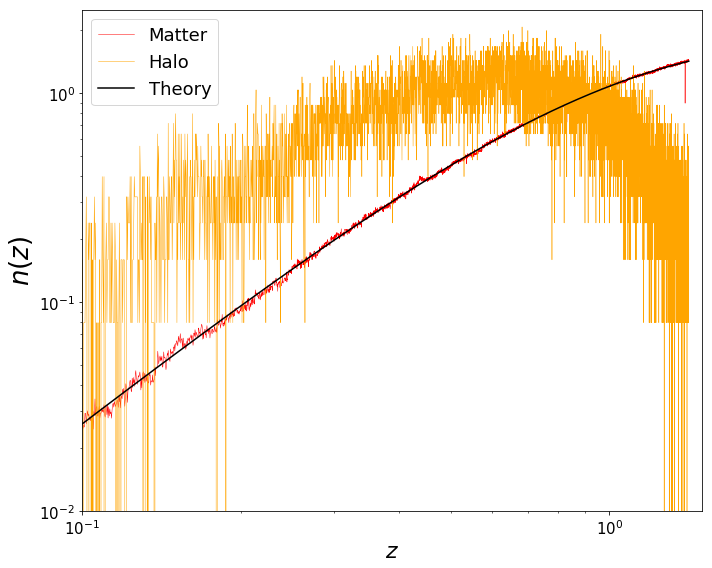

In [32]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1,1.5)
ax.set_ylim(1e-2,2.5)
ax.plot(zarray, nz_normed, 'r-', label='Matter',linewidth=0.5)
ax.plot(zarray, nz_normed_g, 'orange', label='Halo',linewidth=0.5)
# ax.plot(zarray, nz_normed_smooth, 'b-', label='Randoms')
ax.plot(zarray, dndz, 'k-', label='Theory')
ax.legend(fontsize=18)
plt.xlabel(r'$z$', fontsize=22)
plt.ylabel(r'$n(z)$', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tight_layout()




In [33]:
import esutil
gen = esutil.random.Generator(nz_normed, zarray)
z_r = gen.sample(len(ra_o)*2)


In [34]:
nz_r_unnorm, z_edge = np.histogram(z_r, zarray_edges)
nz_r_normed = nz_r_unnorm/(integrate.simps(nz_r_unnorm,zarray))



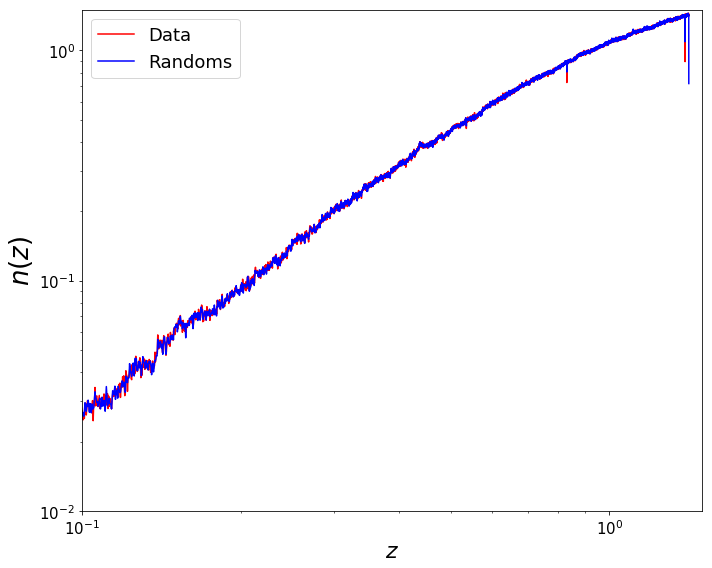

In [35]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1,1.5)
ax.set_ylim(1e-2,1.5)
ax.plot(zarray, nz_normed, 'r-', label='Data')
ax.plot(zarray, nz_r_normed, 'b-', label='Randoms')
ax.legend(fontsize=18)
plt.xlabel(r'$z$', fontsize=22)
plt.ylabel(r'$n(z)$', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tight_layout()





In [26]:
bz_rm_rf = fits.open('/global/project/projectdirs/des/shivamp/actxdes/data_set/buzzard_sims/redmagic_3y3/buzzard_1.9.2+1_3y3_run_redmapper_v6.4.22_redmagic_highdens_0.5-10_randoms.fit')    
bz_rm_f = fits.open('/global/project/projectdirs/des/shivamp/actxdes/data_set/buzzard_sims/redmagic_3y3/buzzard_1.9.2+1_3y3_run_redmapper_v6.4.22_redmagic_highdens_0.5-10.fit')  


In [31]:
z_g = bz_rm_f[1].data['ZSPEC']
z_r = bz_rm_rf[1].data['Z']


In [32]:
nz_g, z_edge = np.histogram(z_g, zarray_edges)
nz_g_normed = nz_g/(integrate.simps(nz_g,zarray))


In [33]:
nz_r, z_edge = np.histogram(z_r, zarray_edges)
nz_r_normed = nz_r/(integrate.simps(nz_r,zarray))



In [40]:
w_r = bz_rm_rf[1].data['WEIGHT']



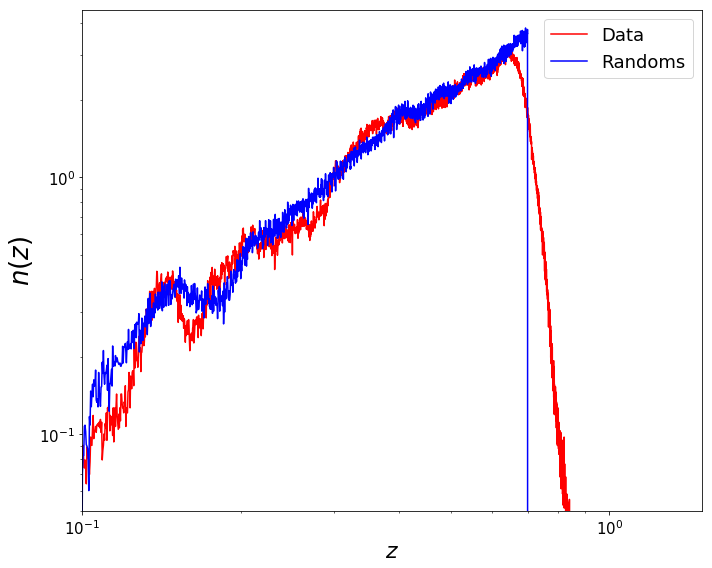

In [38]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1,1.5)
ax.set_ylim(5e-2,4.5)
ax.plot(zarray, nz_g_normed, 'r-', label='Data')
ax.plot(zarray, nz_r_normed, 'b-', label='Randoms')
ax.legend(fontsize=18)
plt.xlabel(r'$z$', fontsize=22)
plt.ylabel(r'$n(z)$', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tight_layout()






